# Init

In [1]:
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import numpy as np
from PIL import Image, ImageTk, ImageFont, ImageDraw
import random
import pandas as pd
from datetime import datetime, timedelta

diff_cmap = plt.get_cmap('PiYG')

rmd = 'c:/Users/Laser/Documents/raw_mikro_data/'

# Functions

In [2]:
def make_coord_list(sqr_size = 490):
    cords = []
    for i in range(0, 5):
        x = 0.5*sqr_size
        y = (-0.5*sqr_size)*i/5
        cords.append([x, y])
        cords.append([-x, y])
        cords.append([-y, x])
        cords.append([y, -x])

        x = 0.5*sqr_size
        y = (0.5*sqr_size)*i/5
        cords.append([x, y])
        cords.append([-x, y])
        cords.append([-y, x])
        cords.append([y, -x])
    return cords


def make_var_list(cords):
    return [[60*v/(490/2) for v in c] for c in cords]


def make_side_mask(c, s = 100):
    width = s
    height = s

    maska = np.zeros((448, 800))
    cx = int(maska.shape[1]/2) + 30 + c[0]
    cy = int(maska.shape[0]/2) + c[1]
    maska = cv2.rectangle(maska, (int(cx-width/2), int(cy-height/2)), (int(cx+width/2), int(cy+height/2)), 1, -1)
    
    return maska


def check_mapka_maske(mapka, mask, thresh = 0.01):
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    
    return pos/(pos+neg)

v_shot_x = 0
v_shot_y = 1
v_angle = 2
v_gain = 3  # count as in count of negative/positive values on the selected area of the map
v_ratio = 4  # check count, same as shot_count but for check map
v_validity = 5


def get_nppixel_count(masked_map, thres=0.01):
    neg = np.where(masked_map < -thres, 1, 0)
    pos = np.where(masked_map > thres, 1, 0)
    tot = np.where(masked_map != 0, 1, 0)
    dead = np.where((masked_map > -thres) & (masked_map < thres) & (masked_map != 0), 1, 0)

    return neg.sum(), pos.sum(), tot.sum(), dead.sum()


def cmap_array(arr, cmap, rng = 1, middle = 0):
     return cmap((arr/rng+1-middle/rng)/2)[:,:,:3]
    

def make_check_mask(shot_point, ang, arr, shot_size=110, check_size=40, span = 25):
    chm = np.zeros((arr.shape[0], arr.shape[1]))
    #     chm = cv2.circle(chm, shot_point, shot_size, 1, 2)
    cang = ang + 180
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    chm = cv2.circle(chm, (px, py), check_size, 1, -1)

    cang = ang + span + 180
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    chm = cv2.circle(chm, (px, py), int(check_size * 0.75), 1, -1)

    cang = ang - span + 180
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    chm = cv2.circle(chm, (px, py), int(check_size * 0.75), 1, -1)

    return chm


def new_validity_array(mapka,
                       direction,
                       aop = [(400, 224), (400, 400)],  # area of operation = [(x, y), (w, h)]
                       shot_size=110,
                       check_size=50,
                       count=100,
                       thres=0.03,
                       angle_count=15):
    val_arr = []

    minx = aop[0][0]-int(aop[1][0]/2)+int(shot_size)
    miny = aop[0][1]-int(aop[1][1]/2)+int(shot_size)
    maxx = aop[0][0]+int(aop[1][0]/2)-int(shot_size)
    maxy = aop[0][1]+int(aop[1][1]/2)-int(shot_size)
        
    val_array = []

    for i in range(0, count):
        shot_point = (minx + int(np.random.random() * (maxx - minx)),
                      miny + int(np.random.random() * (maxy - miny)))
        
        # get shotmask ratios
        shot_mask = np.zeros((mapka.shape[0], mapka.shape[1]))
        shot_mask = cv2.circle(shot_mask, shot_point, shot_size, 1, -1)
        shot_arr = mapka.copy() * shot_mask
        sh_neg, sh_pos, sh_tot, sh_dead = get_nppixel_count(shot_arr, thres = thres)
        if direction == 1: gain = sh_neg/sh_tot
        if direction == -1: gain = sh_pos/sh_tot
        gain *= (1-(sh_dead/sh_tot))  # leave the dead region alone!

        # get checkmask ratios for each angle
        angles = np.linspace(int(360 / angle_count), 360, angle_count)
        for ang in angles:
            chm = make_check_mask(shot_point, ang, mapka.copy(), check_size=check_size)
            ch_arr = mapka.copy() * chm
            ch_neg, ch_pos, ch_tot, ch_dead = get_nppixel_count(ch_arr, thres = thres)
            if direction == 1: ratio = ch_pos/ch_tot
            if direction == -1: ratio = ch_neg/ch_tot
            ratio *= (1-(ch_dead/ch_tot))  # leave the dead alone!
            val_array.append([shot_point[0], shot_point[1], ang, gain, ratio, gain*ratio**2])
        
    val_array = np.array(val_array)
    val_array = np.flip(val_array[np.argsort(val_array[:, 5])], axis=0)
    return val_array


def show_shot_asrgb(val, mapka, shot_size=110, check_size=50, ranger = 0.07):
    rgb_mapka = (255 * cmap_array(mapka.copy(), diff_cmap, rng=ranger)).astype(
        np.uint8)
    rgb_mapka = cv2.circle(rgb_mapka, (int(val[v_shot_x]), int(val[v_shot_y])),
                           shot_size, (0, 0, 0), 2)

    ang = val[v_angle] + 180
    dir_x = int(val[v_shot_x] - shot_size * np.cos(ang * np.pi / 180))
    dir_y = int(val[v_shot_y] - shot_size * np.sin(-ang * np.pi / 180))
    rgb_mapka = cv2.arrowedLine(rgb_mapka,
                                (int(val[v_shot_x]), int(val[v_shot_y])),
                                (dir_x, dir_y), (255, 24, 24), 3)

    rgb_mapka = draw_check_mask(rgb_mapka,
                                (int(val[v_shot_x]), int(val[v_shot_y])),
                                ang,
                                shot_size=shot_size,
                                check_size=check_size)
    return rgb_mapka


def show_pixel_asrgb(img, vrs, ranger = 0.07, check_size = 100):
    rgb_mapka = (255 * cmap_array(img.copy(), diff_cmap, rng=ranger)).astype(
            np.uint8)

    cx, cy = 400, 224
    w, h = 400, 400
    clr = (0, 0, 0)
    rgb_mapka = cv2.rectangle(rgb_mapka, (int(cx-w/2), int(cy-h/2)), (int(cx+w/2), int(cy+h/2)), clr, 2)

    cx, cy = 400+30+int(3*vrs[0]), 224+int(3*vrs[1])
    w, h = check_size, check_size
    clr = (0, 0, 190)
    rgb_mapka = cv2.rectangle(rgb_mapka, (int(cx-w/2), int(cy-h/2)), (int(cx+w/2), int(cy+h/2)), clr, 2)
    
    return rgb_mapka


def draw_check_mask(rgb, shot_point, ang, shot_size=110, check_size=50, span = 25):
    cang = ang
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    rgb = cv2.circle(rgb, (px, py), check_size, (0, 0, 0), 2)

    cang = ang + span
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    rgb = cv2.circle(rgb, (px, py), int(check_size * 0.7), (0, 0, 0), 2)

    cang = ang - span
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    rgb = cv2.circle(rgb, (px, py), int(check_size * 0.7), (0, 0, 0), 2)

    return rgb


def get_datasets(files):
    dates = []
    for file in files:
        dates.append(file[:19])

    dates = list(set(dates))

    all_datasets = []
    for date in dates:
        data_set = []
        for file in files:
            if file.find(date) >= 0:
                data_set.append(file)
        all_datasets.append(data_set)

    return all_datasets


def get_named(single_set):
    dictio = {}
    
    for item in single_set:
        if item.find('mapka_before') >= 0: dictio['mapka_before'] = item
    for item in single_set:
        if item.find('mapka_after') >= 0: dictio['mapka_after'] = item
    for item in single_set:
        if item.find('parameters') >= 0: dictio['parameters'] = item
            
    return dictio


def check_mapka(mapka, thresh = 0.005):
    width = 300
    height = 300

    mask = np.zeros(mapka.shape)

    cx = int(mask.shape[0]/2)
    cy = int(mask.shape[1]/2)
    mask = cv2.rectangle(mask, (int(cy-width/2), int(cx-height/2)), (int(cy+width/2), int(cx+height/2)), 1, -1)
    
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (width*height)-masked[(abs(masked) > thresh)].shape[0]
    
    return pos/(pos+neg+1), dead/(width*height)


def folder_of_tests(folder):
    files = os.listdir(wd + folder)
    all_datasets = get_datasets(files)
    
    ranger = 0.07
    for dataset in all_datasets:
        namel = dataset[0].split(' ')[:3]
        name = '%s %s %s'%(namel[0], namel[1], namel[2])

        names = get_named(dataset)

        f = open(wd + folder + names['parameters'], 'r')
        cnt = f.read()
        f.close()


        fig = plt.figure(figsize=(12, 8))

        img = np.load(wd + folder + names['mapka_before'])
        ax1 = fig.add_subplot(121)
        ch = ax1.imshow(img, cmap=diff_cmap)
        norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
        ch.set_norm(norm)

        img = np.load(wd + folder + names['mapka_after'])
        ax2 = fig.add_subplot(122)
        ch = ax2.imshow(img, cmap=diff_cmap)
        norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
        ch.set_norm(norm)

        ax2.text(900, 400, cnt)
        plt.tight_layout()

        fig.savefig(wd + '/pixelburn_results/%s.png'%name, dpi = 150)
        print(wd + '/pixelburn_results/%s.png'%name)
        plt.close()
        
        
def folder_of_patterns(folder):
    if os.path.isdir(wd + folder.replace('/', '_results/')) == False:
        os.mkdir(wd + folder.replace('/', '_results/'))
    ranger = 0.07
    files = os.listdir(wd + folder)
    xandys = []
    for file in files:
        xandy = file[file.find(' X')+1:file.find('.npy')]
        xandys.append(xandy)

    xandys = list(set(xandys))
    for xandy in xandys:
        selected = [f for f in files if f.find(xandy) >= 0]
        mapki = [f for f in selected if f.find('mapka_') >= 0]

        fig, axes = plt.subplots(1, len(mapki))
        fig.set_size_inches(6*len(mapki), 4)

        if len(mapki) == 1: axes = [axes]

        for i in range(0, len(mapki)):
            name = mapki[i]
            img = np.load(wd + folder + name)
            pos, dead = check_mapka(img, thresh = 0.005)
            ch = axes[i].imshow(img, cmap=diff_cmap)
            norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
            ch.set_norm(norm)
            axes[i].text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))
        fname = selected[0].replace('frame_000', 'result').replace('.npy', '.png')
        fig.savefig(wd + folder.replace('/', '_results/') + fname, dpi = 200)
        print(fname)
        plt.close()
        
        
def folder_of_patterns2(folder):
    if os.path.isdir(wd + folder.replace('/', '_results/')) == False:
        os.mkdir(wd + folder.replace('/', '_results/'))
    ranger = 0.07
    files = os.listdir(rmd + folder)
    xandys = []
    for file in files:
        if file.find('.npy') >= 0:
            xandy = file[file.find(' X')+1:file.find('.npy')]
            xandys.append(xandy)

    xandys = list(set(xandys))
    for xandy in xandys:
        selected = [f for f in files if f.find(xandy) >= 0]
        mapki = [f for f in selected if f.find('mapka_') >= 0]
        fig, axes = plt.subplots(2, len(mapki))
        fig.set_size_inches(6*len(mapki), 8)
        # if len(mapki) == 1: axes = [axes]

        for i in range(0, len(mapki)):
            name = mapki[i]

            # handle the parameters
            param_fpath = rmd + folder + name.replace('mapka', 'burnParams')
            
            if os.path.isfile(param_fpath):
                f = open(param_fpath)
                cnt = f.read().split('\n')
                f.close()
                params = {}
                for l in cnt:
#                     l = line.replace(':', '=')
                    if l.find('=') >= 0:
                        split = l.split('=')
                        params[split[0]] = split[1]

            img = np.load(rmd + folder + name)
            pos, dead = check_mapka(img, thresh = 0.005)

            if params['anim_type'][:-1] == 'shining-moon':
                val = [int(params['paranim_y']), int(params['paranim_x']), int(params['paranim_a'])]
                img = show_shot_asrgb(val, img)
                if len(mapki) == 1:
                    axes[0].imshow(img)
                else:                    
                    axes[0, i].imshow(img)
            if params['anim_type'][:-1] == 'pixel-burn':
                if os.path.isfile(param_fpath):
                    img = show_pixel_asrgb(img, [int(float(params['v5'])), int(float(params['v6']))])
                if len(mapki) == 1:
                    ch = axes[0].imshow(img, cmap=diff_cmap)
                else:                    
                    ch = axes[0, i].imshow(img, cmap=diff_cmap)            
                norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
                ch.set_norm(norm)
                    
            if params['anim_type'] == 'none':
                if len(mapki) == 1:
                    ch = axes[0].imshow(img, cmap=diff_cmap)
                else:                    
                    ch = axes[0, i].imshow(img, cmap=diff_cmap)                
                norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
                ch.set_norm(norm)
            
            if len(mapki) == 1:
                axes[0].text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))
            else:                    
                axes[0, i].text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))
            

            img = np.load(rmd + folder + name.replace('mapka', 'frame'))
            if len(mapki) == 1:
                axes[1].imshow(img)
            else:                    
                axes[1, i].imshow(img)            
            
            # additional info
            if os.path.isfile(param_fpath):
                text_str = ''
                if 'anim_type' in params.keys(): text_str += 'burn type = %s\n'%(params['anim_type'])
                if 'power' in params.keys(): text_str += 'laser power = %2.4f\n'%float(params['power'])
                if 'length' in params.keys(): text_str += 'duration = %2.4f\n'%float(params['length'])
                if 'size' in params.keys(): text_str += 'size = %2.4f\n'%float(params['size'])
                if 'temp' in params.keys(): text_str += 'temp = %2.4f\n'%float(params['temp'])    
                if 'comment' in params.keys(): text_str += 'comment = %s'%params['comment'] 
                if 'result' in params.keys(): text_str += 'result = %s'%params['result']
                if len(mapki) == 1:
                    axes[1].text(0, 500, text_str, va = 'top')
                else:                    
                    axes[1, i].text(0, 500, text_str, va = 'top')
                
            plt.tight_layout()

        fname = mapki[0].replace('mapka', 'result').replace('.npy', '.jpg')
        fig.savefig(wd + folder.replace('/', '_results/') + fname, dpi = 200)
        print(fname)
        plt.close()
        
        
def select_side(mapka, target, check_size = 100, thresh = 0.01):
    '''target = 1 or -1'''
    cords = make_coord_list()
    var_list = make_var_list(cords)
    posnegs = []
    for i in range(0, len(cords)):
        maska = make_side_mask(cords[i], s = check_size)
        posnegs.append(check_mapka_maske(mapka, maska, thresh = thresh))
        
    if target == 1:
        ind = posnegs.index(max(posnegs))
        return var_list[ind]
    if target == -1:
        ind = posnegs.index(min(posnegs))
        return var_list[ind]
    
    
def check_mapka(mapka, size = 400, thresh = 0.01):
    width = size
    height = size

    mask = np.zeros(mapka.shape)

    cx = int(mask.shape[0]/2)
    cy = int(mask.shape[1]/2)
    mask = cv2.rectangle(mask, (int(cy-width/2), int(cx-height/2)), (int(cy+width/2), int(cx+height/2)), 1, -1)
    
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (width*height)-masked[(abs(masked) > thresh)].shape[0]
    
    return pos/(pos+neg+1), dead/(width*height)

# Read data

In [3]:
cols = ['date', 'burn_type', 'burn_number', 'length', 'power', 'factor_before', 'factor_after', 'dead_before', \
        'dead_after', 'dir', 'result']

results = {}
for c in cols:
    results[c] = []
    

folders = ['new_patterning' + str(n).zfill(2) + '/' for n in range(15, 22)]
folders

['new_patterning15/',
 'new_patterning16/',
 'new_patterning17/',
 'new_patterning18/',
 'new_patterning19/',
 'new_patterning20/',
 'new_patterning21/']

In [35]:
for folder in folders[:]:
    print('Processing %s folder'%folder)
    files = os.listdir(rmd + '/pixelburns/' + folder)
    xandys = []
    for file in files:
        if file.find('.npy') >= 0:
            xandy = file[file.find(' X')+1:file.find('.npy')]
            xandys.append(xandy)
    xandys = list(set(xandys))

    file_groups = []
    for xandy in xandys:
        selected = [f for f in files if f.find(xandy) >= 0]
        file_groups.append(selected)

    for fg in file_groups:
#         _ = [print(aas) for aas in fg]
#         print(20*'-')
        count = len([f for f in fg if f.find('mapka') >= 0])
        if len(fg)%4 == 0:
            for num in range(0, count):
                # read burnParams
                fname = [f for f in fg if (f.find('burnParams') >= 0 and f.find(str(num).zfill(3)) >= 0)][0]
                f = open(rmd + '/pixelburns/' + folder + fname, 'r')
                fread = f.read().splitlines()
                keys = [l.split('=')[0] for l in fread if l.find('=') >= 0]
                vals = [l.split('=')[1] for l in fread if l.find('=') >= 0]
                dictio = {}
                for i in range(0, len(keys)):
                    dictio[keys[i]] = vals[i]
                f.close()
                results['date'].append(fname[:19])
                results['burn_type'].append(dictio['anim_type'])
                results['burn_number'].append(num)

                # determine direction
                if count > 1 and num != count-1: direction = dictio['direction']

                # gfactor and dead for before
                fname = [f for f in fg if (f.find('mapka') >= 0 and f.find(str(num).zfill(3)) >= 0)][0]
                img = np.load(rmd + '/pixelburns/' + folder + fname)
                gf, dead = check_mapka(img)
                results['factor_before'].append(gf)
                results['dead_before'].append(dead)

                if dictio['anim_type'] != 'none':
                    results['length'].append(dictio['length'])
                    results['power'].append(dictio['power'])

                    # gfactor and dead for after
                    fname = [f for f in fg if (f.find('mapka') >= 0 and f.find(str(num+1).zfill(3)) >= 0)][0]
                    img = np.load(rmd + '/pixelburns/' + folder + fname)
                    gf, dead = check_mapka(img)
                    results['factor_after'].append(gf)
                    results['dead_after'].append(dead)
                else:
                    results['length'].append('-')
                    results['power'].append('-')
                    results['factor_after'].append('-')
                    results['dead_after'].append('-')

            # could not find direction because no burns were performed
            if direction == 0:
                if dictio['result'] == 'SUCCESS':
                    if gf > 0.75: 
                        direction = 1
                    else:
                        direction = -1

            for d in range(0, count):
                results['dir'].append(direction)
                results['result'].append(dictio['result'])



Processing new_patterning15/ folder
Processing new_patterning16/ folder
Processing new_patterning17/ folder
Processing new_patterning18/ folder
Processing new_patterning19/ folder
Processing new_patterning20/ folder
Processing new_patterning21/ folder


In [36]:
df = pd.DataFrame(results)
df

,date,burn_type,burn_number,length,power,factor_before,factor_after,dead_before,dead_after,dir,result
0,15-03-2022 15.17.28,pixel-burn4,0,50.0000,7.0000,0.768776,0.830405,0.033412,0.043681,1,SUCCESS
1,15-03-2022 15.18.31,pixel-burn4,1,50.0000,6.7500,0.830405,0.951935,0.043681,0.006687,1,SUCCESS
2,15-03-2022 15.19.34,none,2,-,-,0.951935,-,0.006687,-,1,SUCCESS
3,15-03-2022 15.14.10,pixel-burn4,0,50.0000,7.0000,0.580344,0.771253,0.035362,0.045812,-1,SUCCESS
4,15-03-2022 15.15.13,pixel-burn4,1,50.0000,6.7500,0.771253,0.258859,0.045812,0.077881,-1,SUCCESS
...,...,...,...,...,...,...,...,...,...,...,...
1393,17-03-2022 15.15.31,shining-moon3,5,40.0000,5.1667,0.433716,0.257636,0.038562,0.0418,-1,SUCCESS
1394,17-03-2022 15.16.34,shining-moon3,6,40.0000,5.0000,0.257636,0.19472,0.041800,0.104681,-1,SUCCESS
1395,17-03-2022 15.17.38,shining-moon3,7,40.0000,4.8333,0.194720,0.18008,0.104681,0.190887,-1,SUCCESS
1396,17-03-2022 15.18.42,shining-moon3,8,40.0000,4.6667,0.180080,0.118452,0.190887,0.113731,-1,SUCCESS


In [38]:
df.to_csv('results/results.csv')

# Data anlaysis

In [40]:
dateparse = lambda x: datetime.strptime(x, '%d-%m-%Y %H.%M.%S')

df = pd.read_csv('results/results.csv', parse_dates=['date'], date_parser=dateparse)
_ = df.pop(df.columns[0])
df

,date,burn_type,burn_number,length,power,factor_before,factor_after,dead_before,dead_after,dir,result
0,2022-03-15 15:17:28,pixel-burn4,0,50.0000,7.0000,0.768776,0.83040545839542,0.033412,0.04368125,1,SUCCESS
1,2022-03-15 15:18:31,pixel-burn4,1,50.0000,6.7500,0.830405,0.9519351164970963,0.043681,0.0066875,1,SUCCESS
2,2022-03-15 15:19:34,none,2,-,-,0.951935,-,0.006687,-,1,SUCCESS
3,2022-03-15 15:14:10,pixel-burn4,0,50.0000,7.0000,0.580344,0.7712532177034276,0.035362,0.0458125,-1,SUCCESS
4,2022-03-15 15:15:13,pixel-burn4,1,50.0000,6.7500,0.771253,0.2588586146129863,0.045812,0.07788125,-1,SUCCESS
...,...,...,...,...,...,...,...,...,...,...,...
3944,2022-03-20 22:20:41,pixel-burn4,8,50.0000,5.6250,0.464873,0.4845954487154059,0.049438,0.05466875,-1,SUCCESS
3945,2022-03-20 22:21:46,pixel-burn4,9,50.0000,5.6250,0.484595,0.3550499284861368,0.054669,0.04739375,-1,SUCCESS
3946,2022-03-20 22:22:51,shining-moon3,10,40.0000,4.6667,0.355050,0.22842387269616862,0.047394,0.03185,-1,SUCCESS
3947,2022-03-20 22:23:56,shining-moon3,11,40.0000,4.6667,0.228424,0.11704828031648636,0.031850,0.03235,-1,SUCCESS


## Bar chart

In [41]:
d_start = '19-03-2022 18.14.00'
d_start = datetime.strptime(d_start, '%d-%m-%Y %H.%M.%S')

d_end = '20-03-2022 08.30.00'
d_end = datetime.strptime(d_end, '%d-%m-%Y %H.%M.%S')

tdf = df[(df['burn_type'] == 'none') & (df['date'] > d_start) & (df['date'] < d_end)]
tdf = tdf.sort_values(by='date')
tdf[:10]

,date,burn_type,burn_number,length,power,factor_before,factor_after,dead_before,dead_after,dir,result
3477,2022-03-19 18:15:23,none,1,-,-,0.875050,-,0.015312,-,1,SUCCESS
2904,2022-03-19 18:15:31,none,0,-,-,0.928069,-,0.019900,-,1,SUCCESS
3274,2022-03-19 18:15:39,none,0,-,-,0.973351,-,0.010506,-,-1,SUCCESS
2836,2022-03-19 18:15:48,none,0,-,-,0.983839,-,0.000706,-,1,SUCCESS
3019,2022-03-19 18:15:56,none,0,-,-,0.940084,-,0.007994,-,-1,SUCCESS
3265,2022-03-19 18:16:04,none,0,-,-,0.896059,-,0.038887,-,-1,SUCCESS
3233,2022-03-19 18:16:12,none,0,-,-,0.976992,-,0.001706,-,1,SUCCESS
3442,2022-03-19 18:16:20,none,0,-,-,0.927336,-,0.016450,-,-1,SUCCESS
3308,2022-03-19 18:16:28,none,0,-,-,0.913049,-,0.032081,-,-1,SUCCESS
2944,2022-03-19 18:17:40,none,1,-,-,0.899646,-,0.022587,-,1,SUCCESS


In [42]:
res = (tdf['result'] == 'SUCCESS').values

colors = []
for r in res:
    if r:
        colors.append('green')
    else:
        colors.append('red')

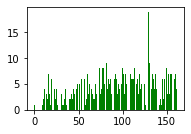

In [47]:
vals = tdf['burn_number'].values
x = range(0, len(vals))

w, h = 7, 5
fig = plt.figure(figsize = (w/2.54, h/2.54))
ax = fig.add_subplot(111)
ax.bar(x, vals, color = colors)
plt.tight_layout()

fig.savefig('barplot.png', dpi = 500)

## Efficiency by day

In [55]:
df.sort_values(by='date')

,date,burn_type,burn_number,length,power,factor_before,factor_after,dead_before,dead_after,dir,result
114,2022-03-15 14:54:55,pixel-burn4,0,50.0000,7.0000,0.713567,0.707657163390892,0.028094,0.026,-1,FAILED
115,2022-03-15 14:55:59,pixel-burn4,1,50.0000,6.7500,0.707657,0.43012002849500663,0.026000,0.07001875,-1,FAILED
116,2022-03-15 14:57:03,pixel-burn4,2,50.0000,6.5000,0.430120,0.3104250666987623,0.070019,0.0653,-1,FAILED
117,2022-03-15 14:58:06,shining-moon3,3,40.0000,6.5000,0.310425,0.16845014527673446,0.065300,0.029875,-1,FAILED
118,2022-03-15 14:59:11,pixel-burn4,4,50.0000,6.0000,0.168450,0.3785006134155642,0.029875,0.0575375,-1,FAILED
...,...,...,...,...,...,...,...,...,...,...,...
3747,2022-03-20 23:44:00,shining-moon3,19,40.0000,4.6667,0.788810,0.7155828321151972,0.065213,0.08245,-1,FAILED
3748,2022-03-20 23:45:06,shining-moon3,20,40.0000,4.6667,0.715583,0.8474779099700828,0.082450,0.10169375,-1,FAILED
3749,2022-03-20 23:46:11,shining-moon3,21,40.0000,4.6667,0.847478,0.8165347864559129,0.101694,0.0182125,-1,FAILED
3751,2022-03-20 23:48:22,shining-moon3,23,40.0000,4.6667,0.796299,0.770802908994841,0.092088,0.1483375,-1,FAILED


In [58]:
d_start = '15-03-2022 00.00.00'
d_start = datetime.strptime(d_start, '%d-%m-%Y %H.%M.%S')

dates = []
for i in range(0, 10):
    dates.append(d_start + timedelta(days = i))


In [69]:
rates = []

for i in range(0, len(dates)-1):
    d_start = dates[i]
    d_end = dates[i+1]

    tdf = df[(df['burn_type'] == 'none') & (df['date'] > d_start) & (df['date'] < d_end)]
    suc = (tdf['result'] == 'SUCCESS').values
    dobre = suc.sum()
    total = len(suc)
    if total == 0:
        total = 1
        dobre = 0
    rates.append(dobre/total)

(0.8, 1.02)

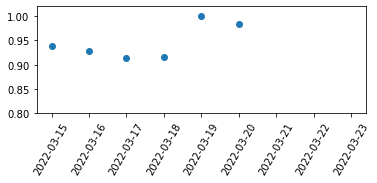

In [85]:
w, h = 15, 5
fig = plt.figure(figsize = (w/2.54, h/2.54))
ax = fig.add_subplot(111)
ax.scatter(dates[:-1], rates)
_ = plt.xticks(rotation = 60)
ax.set_ylim(0.8, 1.02)

## Efficiency by group

In [94]:
tdf = df.sort_values(by='date')
tdf.reset_index(inplace = True)
_ = tdf.pop('index')
tdf

,date,burn_type,burn_number,length,power,factor_before,factor_after,dead_before,dead_after,dir,result
0,2022-03-15 14:54:55,pixel-burn4,0,50.0000,7.0000,0.713567,0.707657163390892,0.028094,0.026,-1,FAILED
1,2022-03-15 14:55:59,pixel-burn4,1,50.0000,6.7500,0.707657,0.43012002849500663,0.026000,0.07001875,-1,FAILED
2,2022-03-15 14:57:03,pixel-burn4,2,50.0000,6.5000,0.430120,0.3104250666987623,0.070019,0.0653,-1,FAILED
3,2022-03-15 14:58:06,shining-moon3,3,40.0000,6.5000,0.310425,0.16845014527673446,0.065300,0.029875,-1,FAILED
4,2022-03-15 14:59:11,pixel-burn4,4,50.0000,6.0000,0.168450,0.3785006134155642,0.029875,0.0575375,-1,FAILED
...,...,...,...,...,...,...,...,...,...,...,...
3944,2022-03-20 23:44:00,shining-moon3,19,40.0000,4.6667,0.788810,0.7155828321151972,0.065213,0.08245,-1,FAILED
3945,2022-03-20 23:45:06,shining-moon3,20,40.0000,4.6667,0.715583,0.8474779099700828,0.082450,0.10169375,-1,FAILED
3946,2022-03-20 23:46:11,shining-moon3,21,40.0000,4.6667,0.847478,0.8165347864559129,0.101694,0.0182125,-1,FAILED
3947,2022-03-20 23:48:22,shining-moon3,23,40.0000,4.6667,0.796299,0.770802908994841,0.092088,0.1483375,-1,FAILED


In [109]:
groups = []
cur_date = tdf['date'][0]

num_start = 0
num_end = 0
for i in range(1, len(tdf)):
    if tdf['date'][i] < cur_date + timedelta(minutes = 3):
        num_end += 1
    else:
#         print(cur_date)
#         print(tdf['date'][i])
#         print(20*'-')
        temp = tdf[num_start+1:num_end+1]
        groups.append(temp)
        num_start = num_end
    
    cur_date = tdf['date'][i]

### Overall

In [160]:
dates = []
rates = []
shots = []
for group in groups:
    if (group['burn_type'] == 'none').sum() > 20:
        suc = (group['result'] == 'SUCCESS').values
        dobre = suc.sum()
        total = len(suc)
        if total == 0:
            total = 1
            dobre = 0
        rates.append(dobre/total)
        date = group['date'].values[0]
        dates.append(str(pd.to_datetime(date).strftime("%Y.%m.%d, %H:%M:%S")))
        
        # num of shots:
        shot = (group['burn_type'] == 'none').sum()
        shots.append(shot)

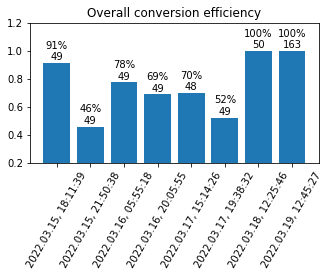

In [171]:
w, h = 12, 10
fig = plt.figure(figsize = (w/2.54, h/2.54))
ax = fig.add_subplot(111)
ax.bar(range(0, len(rates)), rates)
plt.xticks(range(0, len(rates)), dates)
_ = plt.xticks(rotation = 60)

for i in range(0, len(dates)):
    tex = '%2.0f%s\n%d'%(100*rates[i], '%', shots[i])
    ax.text(i, rates[i]+0.02, tex, ha='center')

ax.set_title('Overall conversion efficiency')
ax.set_ylim(0.2, 1.2)
plt.tight_layout()
fig.savefig('analiza/efficiency_by_group.png', dpi = 300)

### Single shot

In [177]:
group = groups[1][groups[1]['burn_type'] == 'none']
group

,date,burn_type,burn_number,length,power,factor_before,factor_after,dead_before,dead_after,dir,result
139,2022-03-15 17:44:07,none,1,-,-,0.002062,-,-0.000250,-,-1,SUCCESS
141,2022-03-15 17:45:18,none,1,-,-,0.999994,-,-0.005006,-,1,SUCCESS
143,2022-03-15 17:46:32,none,1,-,-,0.122773,-,0.032519,-,-1,SUCCESS
147,2022-03-15 17:49:51,none,3,-,-,0.907643,-,0.018219,-,1,SUCCESS
150,2022-03-15 17:52:09,none,2,-,-,0.999994,-,-0.005006,-,1,SUCCESS
153,2022-03-15 17:54:25,none,2,-,-,0.111425,-,0.024575,-,-1,SUCCESS
156,2022-03-15 17:56:40,none,2,-,-,0.939709,-,0.006806,-,1,SUCCESS
158,2022-03-15 17:57:51,none,1,-,-,0.094633,-,0.016600,-,-1,SUCCESS
160,2022-03-15 17:59:06,none,1,-,-,0.029564,-,0.003012,-,-1,SUCCESS
163,2022-03-15 18:01:19,none,2,-,-,0.889373,-,0.006125,-,1,SUCCESS


In [ ]:
for ind in range(0, len(group)):
    

In [178]:
len('universuty of warsaw')

20

In [185]:
def toBinary(a):
    l,m=[],[]
    for i in a:
        l.append(ord(i))
    for i in l:
        m.append(int(bin(i)[2:]))
    return m

In [228]:
binary = toBinary('Szachownica')
# binary = np.array(binary)

01010011
01111010
01100001
01100011
01101000
01101111
01110111
01101110
01101001
01100011
01100001


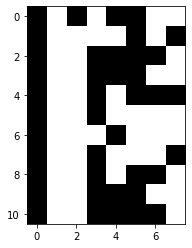

In [229]:
img = np.zeros((len(binary), 8))

for row in range(0, len(img)):
    b = str(binary[row])
    while(len(b) < 8):
        b = '0' + b
    print(b)
    for col in range(0, len(b)):
        znak = (b[col] == '1')
        img[row, col] = znak

plt.imshow(img, cmap = 'gray')

In [210]:
str(binary[0])

'1000011'

In [211]:
img.shape

(9, 8)

In [212]:
img[8, 0]

0.0

In [213]:
img

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [214]:
len(img)

9